# Figure 5
<img src="img/fig5.png",width=400>
Power spectral properties of motor cortical recordings and relation to estimated phase-amplitude coupling. A, A 50 Hz lowpass filter was applied to attenuate high gamma power.
B, When extrema sharpness was recalculated on these lowpass-filtered signals, there remained a strong positive correlation with statistical PAC in the original signal. C, Histogram of correlation
coefficients between sharpness ratio and amplitude across all beta cycles in a recording. Each count is one 30 s recording. D, There is a positive correlation between estimated PAC and beta power.
E, A strong positive correlation between sharpness ratio and estimated PAC (modulation index) remains even after beta power is regressed out. F, Average power spectra across all subjects before
DBS (black) and during DBS (blue). Shaded region represents SEM. B, D, E, Each dot indicates one 30 s recording.

**Imports**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

In [2]:
import util

**Load data**

In [3]:
ecog = util.loadPD()
Fs, t, S, Sdy, flo, fhi = util.loadmeta()

**Calculate shape measures**

In [4]:
widthS = 5 # hyperparameter for calculating sharpness

pks, trs, pksharp, trsharp, esrs, \
peaktotrough, risteep, desteep, rdsrs, \
risetodecay = util.measure_shape(ecog, widthS=widthS)

**Calculate PAC**

In [5]:
pac = util.measure_pac(ecog, flo, fhi)

**Calculate PSDS for all subjects**

In [6]:
f, psd = util.measure_psd(ecog,Hzmed=1)

**Calculate power in beta and high gamma bands**

In [7]:
bp, hgp, tp = util.measure_power(ecog)

# A
### Apply 50Hz low-pass filter to remove high gamma

In [8]:
# Design low-pass filter
from scipy import signal
Ntaps = 250
fc = 50
taps = signal.firwin(Ntaps,fc*2/Fs)

In [9]:
# Apply 50Hz lowpass filter
ecogLow = util._blankecog()
for s in range(S):
    ecogLow['B'][s] = np.convolve(ecog['B'][s], taps, 'same')
    ecogLow['D'][s] = np.convolve(ecog['D'][s], taps, 'same')

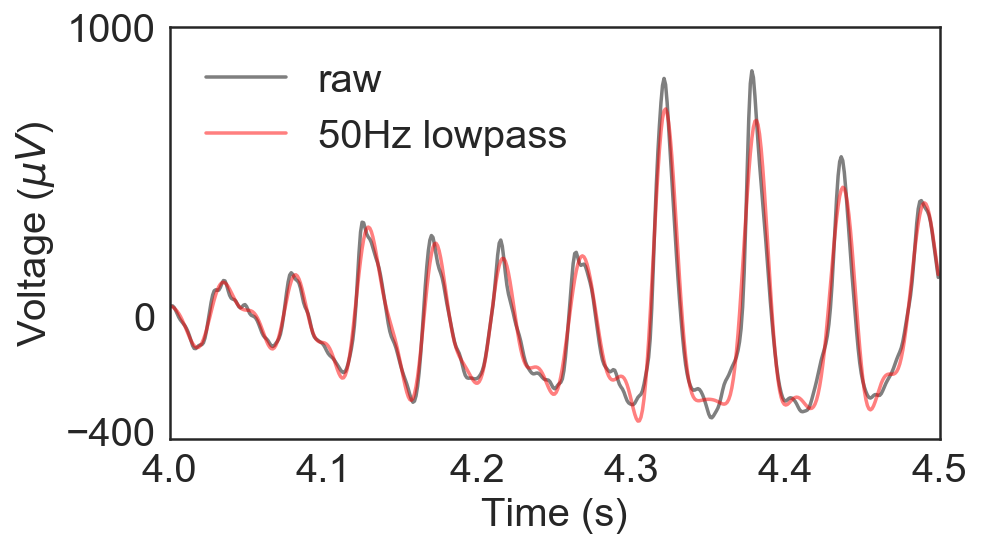

In [10]:
# Visualize low-passed data
s = 0
trange = [4,4.5]
t = np.arange(0,30,.001)
tidx = np.logical_and(t>=trange[0],t<trange[1])
plt.figure(figsize=(7,4))
plt.plot(t[tidx],ecog['B'][s][tidx],'k-',alpha=0.5,label='raw')
plt.plot(t[tidx],ecogLow['B'][s][tidx],'r-',alpha=0.5,label='50Hz lowpass')
plt.xlim((trange))
plt.legend(loc='best',fontsize=20)
plt.xlabel('Time (s)',size=20)
plt.ylabel('Voltage ($\mu V$)',size=20)
plt.xticks(size=20)
plt.yticks((-400,0,1000),size=20)
plt.tight_layout()

# B
### Compare PAC to shape after low pass filter

In [11]:
# Calculate shape on new ecog
widthS = 5
pksLow, trsLow, pksharpLow, trsharpLow, esrsLow, \
peaktotroughLow, risteepLow, desteepLow, rdsrsLow, \
risetodecayLow = util.measure_shape(ecogLow, widthS=widthS)

(0.79634648024294963, 5.478856802680823e-06)


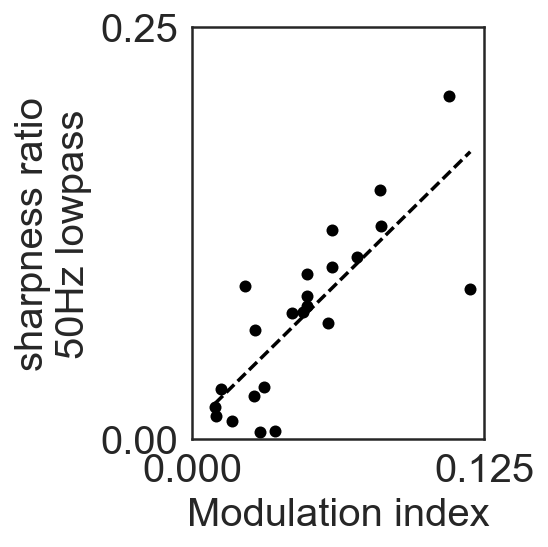

In [12]:
# Visualize relationship between PAC and sharpness ratio
from plt import scatt_corr
scatt_corr(pac['B'],esrsLow['B'], xlabel='Modulation index',ylabel='sharpness ratio\n50Hz lowpass',xlim=(0,.125),ylim=(0,.25),
          figsize=(4,4),showline=True)
print(sp.stats.pearsonr(pac['B'], esrsLow['B']))

# C
### Sharpness ratio and beta amplitude relationship

In [14]:
#Calculate cycle-resolution ESR
from shape import esr
cycleesr = util._blankecog()
pthent = False
for s in range(S):
    cycleesr['B'][s] = esr(ecog['B'][s], pks['B'][s], trs['B'][s], widthS, Fs = Fs, fosc = flo, pthent = pthent, esrmethod = 'adjacent')
    cycleesr['D'][s] = esr(ecog['D'][s], pks['D'][s], trs['D'][s], widthS, Fs = Fs, fosc = flo, pthent = pthent, esrmethod = 'adjacent')

In [15]:
# Calculate difference in voltage between each peak and subsequent trough (beta amplitude)
# Note that this excludes peaks and troughs in the same way as the esr function
def calcdV(x, pks, trs, pthent):
    if pthent == True:
        if pks[0] > trs[0]:
            trs = trs[1:]
        if pks[-1] > trs[-1]:
            pks = pks[:-1]
            
        P = len(pks)
        dVs = np.zeros(P)
        for p in range(P):
            dVs[p] =x[pks[p]] - x[trs[p]]
            
    else:
        if pks[0] < trs[0]:
            pks = pks[1:]
        if pks[-1] < trs[-1]:
            trs = trs[:-1]
            
        T = len(trs)
        dVs = np.zeros(T)
        for t in range(T):
            dVs[t] =x[pks[t]] - x[trs[t]]
   
    return dVs

dVpt = util._blankecog()
for s in range(S):
    dVpt['B'][s] = calcdV(ecog['B'][s],pks['B'][s],trs['B'][s],pthent)
    dVpt['D'][s] = calcdV(ecog['D'][s],pks['D'][s],trs['D'][s],pthent)

Ttest_1sampResult(statistic=6.1008708791134474, pvalue=2.2114497446060841e-07)


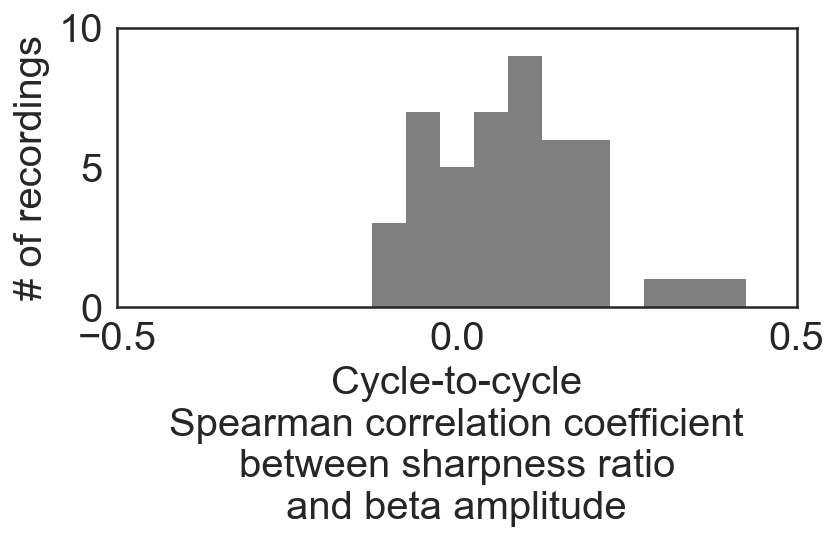

In [16]:
# Sharpness ratio correlates with beta amplitude across subjects:
r_srba = util._blankecog(dtype=float)
for s in range(S):
    r_srba['B'][s],_ = sp.stats.spearmanr(cycleesr['B'][s],dVpt['B'][s])
    r_srba['D'][s],_ = sp.stats.spearmanr(cycleesr['D'][s],dVpt['D'][s])
    
r_srba_all = np.hstack((r_srba['B'],r_srba['D']))

bins = np.arange(-.5,.5,.05)
rcount, binedges = np.histogram(r_srba_all,bins)

plt.figure(figsize=(6,4))
plt.bar(bins[:-1],rcount,bins[1]-bins[0],color='0.5')
plt.xlabel('Cycle-to-cycle\nSpearman correlation coefficient\nbetween sharpness ratio\nand beta amplitude',size=20)
plt.ylabel('# of recordings',size=20)
plt.xlim((-.5,.5))
plt.xticks((-.5,0,.5),size=20)
plt.yticks((0,5,10),size=20)
plt.tight_layout()

print(sp.stats.ttest_1samp(r_srba_all,0))

# D
### PAC is positively correlated with beta power

In [17]:
# Calculate mean sharpness for all peaks and troughs
pksharpmean = util._blankecog(dtype=float)
trsharpmean = util._blankecog(dtype=float)
for s in range(S):
    pksharpmean['B'][s] = np.mean(pksharp['B'][s])
    pksharpmean['D'][s] = np.mean(pksharp['D'][s])
    trsharpmean['B'][s] = np.mean(trsharp['B'][s])
    trsharpmean['D'][s] = np.mean(trsharp['D'][s])

In [18]:
def ungroup(x):
    xflat = []
    for k in x.keys():
        xflat = np.append(xflat,x[k])
    return xflat

ubp = ungroup(bp)
upksharpmean = ungroup(pksharpmean)
utrsharpmean = ungroup(trsharpmean)
uesrs = ungroup(esrs)
urdsrs = ungroup(rdsrs)
upac = ungroup(pac)

(0.36959940105075356, 0.011472200172381345)


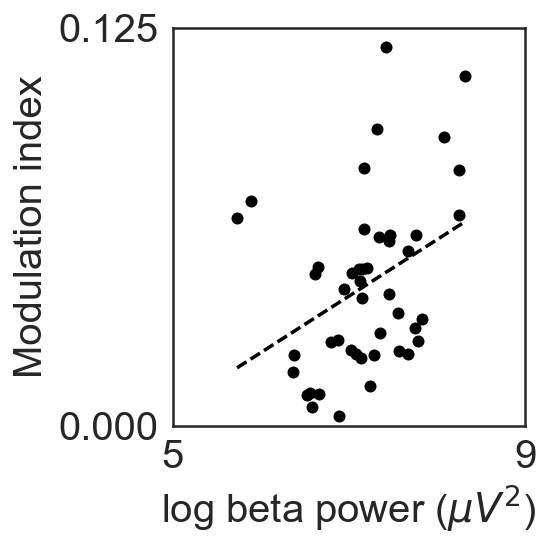

In [19]:
# Show power correlated with PAC
scatt_corr(ubp, upac, xlabel='log beta power ($\mu V^2$)',ylabel='Modulation index',xlim=(5,9),ylim=(0,.125),
          figsize=(4,4),showline=True)
print(sp.stats.pearsonr(ubp,upac))

# E
### Control for beta power when correlate sharpness ratio and pac

In [20]:
def regressout(x,y):
    """Regress x out of y to get a new y value"""
    mb = np.polyfit(x,y,1)
    return y - mb[1] - x*mb[0]

pacB_regbp = regressout(bp['B'],pac['B'])

(0.86539869838825678, 9.7820987335617302e-08)


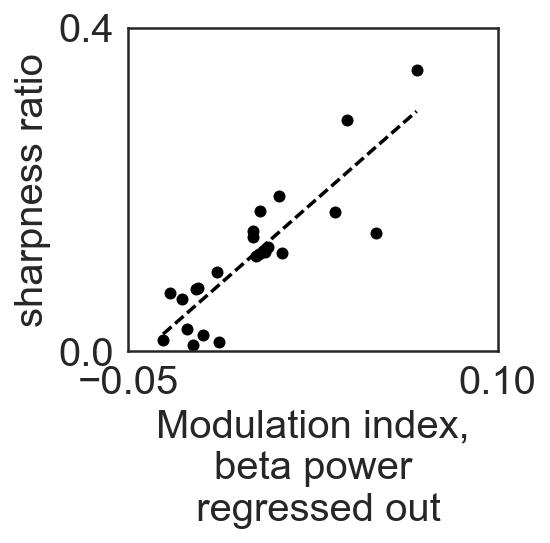

In [21]:
# Visualize relationship between PAC and sharpness ratio
scatt_corr(pacB_regbp,esrs['B'], xlabel='Modulation index,\nbeta power\n regressed out',ylabel='sharpness ratio',xlim=(-.05,.1),ylim=(0,.4),
          figsize=(4,4),showline=True)
print(sp.stats.pearsonr(pacB_regbp, esrs['B']))

# F
### Average PSDs for both groups

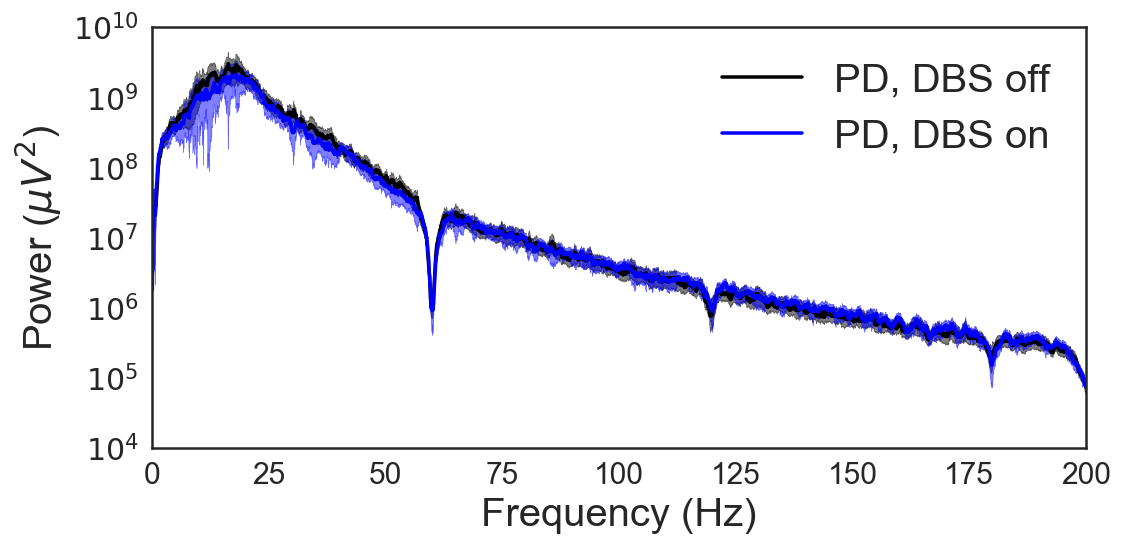

In [22]:
# Mean psds
psdBmean = np.mean(psd['B'],0)
psdBstd = np.std(psd['B'])/np.sqrt(np.shape(psd['B'])[0])
psdDmean = np.mean(psd['D'],0)
psdDstd = np.std(psd['B'])/np.sqrt(np.shape(psd['B'])[0])

plt.figure(figsize=(8,4))
plt.semilogy(f,psdBmean,color='k',label='PD, DBS off')
ax1 = plt.gca()
ax1.fill_between(f, psdBmean, psdBmean+psdBstd,color='k',alpha=.5)
ax1.fill_between(f, psdBmean, psdBmean-psdBstd,color='k',alpha=.5)
plt.semilogy(f,psdDmean,color='b',label='PD, DBS on')
ax1.fill_between(f, psdDmean, psdDmean+psdDstd, color='b', alpha=.5)
ax1.fill_between(f, psdDmean, psdDmean-psdDstd, color='b', alpha=.5)
plt.xlim((0,200))
plt.ylim((10**4,10**10))
plt.ylabel('Power ($\mu V ^2$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(loc='best',fontsize=20)
plt.tight_layout()

# Other statistics

### [after restricting analysis to only the cycles in the top 10% of beta amplitude for each recording]: there is a decrease in sharpness ratio with DBS application (paired t test, t(22)=2.6, p=0.015)

In [33]:
widthS = 5
ampPC = 90
pksBT, trsBT, pksharpBT, trsharpBT, esrsBT, \
peaktotroughBT, risteepBT, desteepBT, rdsrsBT, \
risetodecayBT = util.measure_shape(ecog, widthS=widthS, ampPC=ampPC)

In [37]:
print(sp.stats.ttest_rel(esrsBT['B'],esrsBT['D']))

Ttest_relResult(statistic=2.6632681081908647, pvalue=0.014199637120421075)


### [after restricting analysis to only the cycles in the top 10% of beta amplitude for each recording]: there is a strong correlation between sharpness ratio and PAC (r=0.84, p< $10^{-6}$).

In [35]:
print(sp.stats.pearsonr(pac['B'], esrsBT['B']))

(0.84282888548980284, 4.4876394486752116e-07)


### Sharpness ratio and steepness ratio both individually correlate with statistical PAC after holding the other metric constant (partial correlations, sharpness ratio: r = 0.70, p = 0.0002; steepness ratio: r = 0.44, p = 0.034) and together explain 93% of the variance in statistical PAC of PD patients before DBS

In [30]:
pacB_regrdsr = regressout(rdsrs['B'],pac['B'])
print(sp.stats.pearsonr(pacB_regrdsr, esrs['B']))

(0.69509634740858173, 0.00023198715581206904)


In [32]:
pacB_regesr = regressout(esrs['B'],pac['B'])
print(sp.stats.pearsonr(pacB_regesr, rdsrs['B']))

(0.44369501493600488, 0.03394234660212031)


In [28]:
#  GLM predict PAC from sharpness ratio and steepness ratio
import statsmodels.api as sm
X_pre = np.vstack((esrs['B'],rdsrs['B']))
X = X_pre.T
X = sm.add_constant(X)

# Run GLM
y = pac['B']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print(1 - np.var(res.resid_pearson) / np.var(y))

0.928058375397


### no effect of DBS on the beta frequency in PD patients (paired t test, t(22)=-0.84, p=0.41)

In [25]:
# Calculate number of peaks and frequency for each subject
betafreqs = util._blankecog(dtype=float)
boundaryS = 100
T = 30 - 2*boundaryS/np.float(Fs)
for s in range(S):
    betafreqs['B'][s] = len(pks['B'][s])/T
    betafreqs['D'][s] = len(pks['D'][s])/T
    
# Compare frequency across groups
print(sp.stats.ttest_rel(betafreqs['B'],betafreqs['D']))

Ttest_relResult(statistic=-0.84006861636114127, pvalue=0.40990699749767789)
